In [ ]:
%%capture
! pip install timm segmentation_models_pytorch

In [5]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import segmentation_models_pytorch as smp
from torchvision.models import segmentation as seg

%matplotlib inline

In [6]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Pseudo_labels.tar.xz')
my_tar.extractall()
my_tar.close()

# Image path list

In [ ]:
original_image_path = '/content/Dataset/1.training/1.training'
cutmix_image_path = '/content/Dataset/cutmix_augmentation'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

In [ ]:
original_mask_path = '/content/1.training_pseudo_labels'
cutmix_mask_path = '/content/cutmix_augmentation_pseudo_labels'
constant_mask_path = '/content/data_border_constant_pseudo_labels'
reflect_mask_path = '/content/data_border_reflect_pseudo_labels'

In [ ]:
image_path_list = []

In [ ]:
def img_list(data_path, label_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    image_path_list.append([data_path + '/' + str(i), label_path + '/' + str(i)])

In [ ]:
# loading image paths
img_list(original_image_path, original_mask_path)
img_list(cutmix_image_path, cutmix_mask_path)
img_list(constant_image_path, constant_mask_path)
img_list(reflect_image_path, reflect_mask_path)

In [ ]:
np.random.shuffle(image_path_list)

In [ ]:
image_path_list[np.random.randint(0, 12000)]

['/content/Dataset/1.training/1.training/1221636-26559-48215-[0, 1, 0].png',
 '/content/1.training_pseudo_labels/1221636-26559-48215-[0, 1, 0].png']

image_path_list = [x for x in image_path_list if ('[1, 0, 0]' in x[0]) or\
                                                 ('[0, 1, 0]' in x[0]) or\
                                                 ('[0, 0, 1]' in x[0])]

# sorting the image path list from the original list to match the number of tumor-stroma pair to the rest of the dataset and the cut-mix aug data
tumor = [x for x in image_path_list if '[1, 0, 0]' in x[0]]
stroma = [x for x in image_path_list if '[0, 1, 0]' in x[0]]
normal = [x for x in image_path_list if '[0, 0, 1]' in x[0]]
tum_str = [x for x in image_path_list if '[1, 1, 0]' in x[0]][:4000]
str_nor = [x for x in image_path_list if '[0, 1, 1]' in x[0]]
tum_nor = [x for x in image_path_list if '[1, 0, 1]' in x[0]]
all_tis = [x for x in image_path_list if '[1, 1, 1]' in x[0]]

np.random.shuffle(tumor)
np.random.shuffle(stroma)
np.random.shuffle(normal)
np.random.shuffle(tum_str)
np.random.shuffle(str_nor)
np.random.shuffle(tum_nor)
np.random.shuffle(all_tis)

test_list =[]
train_list = []

# train test splits
tumor, test = train_test_split(tumor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

stroma, test = train_test_split(stroma, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

normal, test = train_test_split(normal, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_str, test = train_test_split(tum_str, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

str_nor, test = train_test_split(str_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_nor, test = train_test_split(tum_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

all_tis, test = train_test_split(all_tis, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

train_list.extend(tumor)
train_list.extend(stroma)
train_list.extend(normal)
train_list.extend(tum_str[:2000])
train_list.extend(str_nor)
train_list.extend(tum_nor)
train_list.extend(all_tis)

np.random.shuffle(train_list)

In [ ]:
len(image_path_list)

36273

len(test_list)

## Creating the dataset class

In [ ]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    mask = cv2.imread(self.image_list[idx][1])/255
    mask = mask.astype('float32')
    #sample = {'image': image, 'mask': mask}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
      mask = self.transform(mask)
    
    return image, mask
    #return sample['image'], sample['mask']

36273
0 (224, 224, 3) (224, 224, 3)
1 (224, 224, 3) (224, 224, 3)
2 (224, 224, 3) (224, 224, 3)
3 (224, 224, 3) (224, 224, 3)


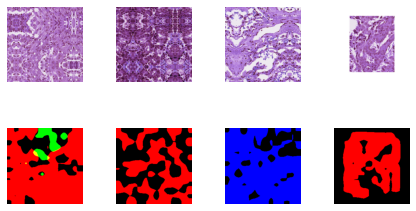

In [ ]:
# check if the dataloader works
check_loader = LUAD(image_list=image_path_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, mask = check_loader[i]

    print(i, image.shape, mask.shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(image)

    ax = plt.subplot(2, 4, i + 1 + 4)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.axis('off')
    plt.imshow(mask)

    if i == 3:
        plt.show()
        break

In [ ]:
random_augs = [#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomVerticalFlip(p=0.5),
               transforms.RandomRotation(30),
               #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ]

# creatin the train dataset
train_dataset = LUAD(image_path_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                     #transforms.RandomApply(random_augs, p=0.6),
                                                     ]))

# creating the test dataset
#test_dataset = LUAD(test_list,
#                    transform = transforms.Compose([transforms.ToTensor(),
#                                                    transforms.Resize((224, 224)),
#                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
#                                                    ))

In [ ]:
batch_size = 32

In [ ]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              sampler = None,
                              batch_sampler = None,
                              num_workers = 0,
                              collate_fn = None,
                              pin_memory = False,
                              drop_last = False,
                              timeout = 0,
                              worker_init_fn=None)

# test dataloader
#test_dataloader = DataLoader(test_dataset,
#                             batch_size = batch_size,
#                             shuffle = True,
#                             num_workers = 1,
#                             )

In [ ]:
len(train_dataloader)

1134

In [ ]:
batch = next(iter(train_dataloader))
images, labels = batch
print(images.shape, labels.shape, type(images), type(labels), images.dtype, labels.dtype)

torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.float32


# Creating the model

model = seg.deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT',
                               progress = True,
                               #num_classes = 3,
                               #weights_backbone = 'ResNet50_Weights.IMAGENET1K_V1',
                               )
model.classifier = seg.deeplabv3.DeepLabHead(2048, 3)
model.aux_classifier = seg.deeplabv3.FCNHead(1024, 3)

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet50', classes=3, activation=None, ).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
model.eval()
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Checking model properties

model.train()
model(images.to(device))

out = model(images.to(device))
out.shape

y_p = nn.functional.softmax(out, dim = -1)
y_p

#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()
#y_p = nn.Threshold(0.25, 1.0)(y_p)
y_p

y_p.shape

'''
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')
'''

l = labels.to(device)

l = torch.tensor(l).to(device)

y_p.dtype

accuracy_score(l.cpu().detach().numpy().argmax(axis=1),
               y_p.cpu().detach().numpy().argmax(axis=1))

loss = [smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()]

loss(out, l)

## Training and validation

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               #eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False,)
  for batch, (x, y) in loop:
    
    #if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    
    y_pred = nn.functional.softmax(model_out, dim = -1)
    #print(y_pred.shape, y_pred.dtype)
    #print(y.shape, y.dtype)
    # calculate loss
    loss = loss_fn(model_out, y)
    
    train_loss += loss
    #train_acc += eval_fn(y.cpu().detach().numpy().argmax(axis=1),
    #                     y_pred.cpu().detach().numpy().argmax(axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  #train_acc /= len(data_loader)
  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")
  print(f"Train loss: {train_loss:.5f}")

In [ ]:
loss = smp.utils.losses.DiceLoss()# + smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.Fscore(beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Accuracy(threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Recall(eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
    smp.utils.metrics.Precision(eps=1e-7, threshold=0.5, activation=None, ignore_channels=None),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters()),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    device=device,
    verbose=False,
)

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(model_out, y)
      test_acc += eval_fn(y.cpu().detach().numpy().astype('float32'),
                          test_pred.cpu().detach().numpy().astype('float32'))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [ ]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/deeplabv3plus_dice_resnet50_02.pth'

In [ ]:
epochs = 25

In [ ]:
valid_acc = -np.inf

In [ ]:
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch + 1} / {epochs}\n---------")
  
  train_step(data_loader=train_dataloader,
             model=model,
             #loss_fn=nn.CrossEntropyLoss(),
             #loss_fn=torch.nn.MSELoss(reduction='mean'),
             loss_fn=smp.utils.losses.DiceLoss(),
             opt=torch.optim.SGD(model.parameters(), lr=0.0001, nesterov=True, momentum=0.09),
             #eval_fn=accuracy_score,
             )
  
  #model.train()
  #train_logs = train_epoch.run(train_dataloader)
  '''
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch16_224,
                                  loss_fn=nn.MultiLabelSoftMarginLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}")
'''
torch.save(obj = model.state_dict(), f = model_save_path)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 / 25
---------


  0%|          | 0/1134 [00:00<?, ?it/s]

KeyboardInterrupt: ignored